In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-05-24 04:57:18.536980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 04:57:18.537129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 04:57:18.712360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [106]:
num_users = 1000
num_items = 150


In [107]:
user_ids = np.random.randint(1, num_users+1, size=num_users)
item_ids = np.random.randint(1, num_items+1, size=num_items)
print(user_ids.shape, item_ids.shape)
print(user_ids[:5], item_ids[:6])

(1000,) (150,)
[344 354 455 737  96] [ 31  59   2  17  36 108]


In [108]:
ratings = np.zeros((num_users, num_items))
for user in range(num_users):
    num_rated_items = np.random.randint(10, 50)  
    rated_items = np.random.choice(num_items, size=num_rated_items, replace=False)
    ratings[user, rated_items] = np.random.randint(1, 6, size=num_rated_items)
ratings.shape 

(1000, 150)

In [109]:
data = [(user_ids[i], item_ids[j], ratings[i][j]) for i in range(num_users) for j in range(num_items)]
data[0], len(data)

((344, 31, 0.0), 150000)

## Data is in the format of (user_id, item_id, rating)

In [110]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
len(train_data), len(test_data)

(120000, 30000)

In [111]:
class DeepFM(tf.keras.Model):
    """
    Deep Factorization Machine
    """
    def __init__(self, num_users, num_items, embedding_size, network_units):
        super(DeepFM, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users+1, embedding_size)
        self.item_embedding = tf.keras.layers.Embedding(num_items+1, embedding_size)
        self.network = tf.keras.Sequential([
            tf.keras.layers.Dense(unit, activation='relu') for unit in network_units
        ])
        self.output_layer = tf.keras.layers.Dense(1)
        
    def call(self, x):
        user_id, item_id = x
        user_embedding = self.user_embedding(user_id)
        item_embedding = self.item_embedding(item_id)
        
        interaction = user_embedding + item_embedding 
        
        fm_output = tf.reduce_sum(interaction, axis=1, keepdims=True)
        
        network_inp = tf.concat([user_embedding, item_embedding], axis=1)
        network_out = self.network(network_inp)
        
        # Combine FM and DNN outputs
        output = tf.concat([fm_output, network_out], axis=1)
        output = self.output_layer(output)
        
        return output

In [112]:
model = DeepFM(num_users, num_items, embedding_size=32, network_units=[64, 32])
print(model)
model.compile(optimizer='adam', loss='mean_squared_error')
print(model)

<DeepFM name=deep_fm_9, built=False>
<DeepFM name=deep_fm_9, built=False>


In [113]:
len(train_data), len(train_data[0])

(120000, 3)

In [114]:
[np.array(train_data)[:, 0], np.array(train_data)[:, 1],  np.array(train_data)[:, 2]]

[array([716., 714., 690., ..., 698., 123., 824.]),
 array([148.,   6.,  15., ..., 146., 117., 128.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [115]:
train_data_array = np.array(train_data)

train_user_ids = train_data_array[:, 0]
train_item_ids = train_data_array[:, 1]

train_ratings = train_data_array[:, 2]

test_data_array = np.array(test_data)

test_user_ids = test_data_array[:, 0]
test_item_ids = test_data_array[:, 1]

test_ratings = test_data_array[:, 2]

test_user_ids[:5],test_item_ids[:5],test_ratings[:5],train_user_ids[:5],train_item_ids[:5],train_ratings[:5]

(array([631., 219., 380., 270., 796.]),
 array([ 90.,  65., 137., 123., 139.]),
 array([0., 0., 0., 2., 0.]),
 array([716., 714., 690., 125., 725.]),
 array([148.,   6.,  15.,  15.,  37.]),
 array([0., 0., 0., 0., 0.]))

In [116]:
history = model.fit(
    [train_user_ids, train_item_ids],
    
    train_ratings,
    
    epochs=10,
    
    batch_size=32,
    
    validation_data=([test_user_ids, test_item_ids], test_ratings)
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.7849 - val_loss: 1.7722
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.7683 - val_loss: 1.7748
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7613 - val_loss: 1.7789
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7509 - val_loss: 1.7872
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.7008 - val_loss: 1.8010
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.6912 - val_loss: 1.8155
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.6888 - val_loss: 1.8222
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.6554 - val_loss: 1.8400
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.6185 - val_loss: 1.8771
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.6013 - val_loss: 1.9192


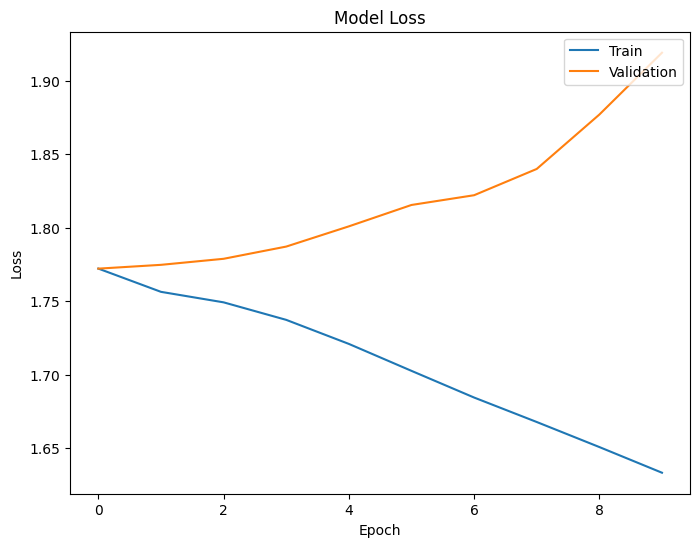

In [118]:
import matplotlib.pyplot as plt

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
